<a href="https://colab.research.google.com/github/Starksood/Experimental_Conundrums/blob/main/Ch10_Windowed_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass  

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



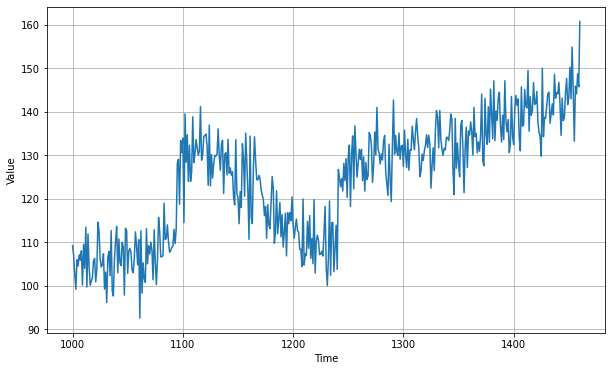

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
  print(feature)
  print(label)

tf.Tensor(
[[ 96.743866 104.419754  97.02101   98.121     90.97218   98.2265
   88.43695   92.70534  104.4956   104.69139  102.958694  96.065735
  100.73142  101.0215    95.31739  108.69608  105.63593  100.2145
  101.52411  102.50212 ]], shape=(1, 20), dtype=float32)
tf.Tensor([91.32221], shape=(1,), dtype=float32)


In [7]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)                                
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=50, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
46/46 [==============================] - 4s 28ms/step - loss: 1118.7391
Epoch 2/50
46/46 [==============================] - 1s 7ms/step - loss: 61.5576
Epoch 3/50
46/46 [==============================] - 1s 10ms/step - loss: 45.7965
Epoch 4/50
46/46 [==============================] - 1s 9ms/step - loss: 53.2088
Epoch 5/50
46/46 [==============================] - 1s 8ms/step - loss: 44.8732
Epoch 6/50
46/46 [==============================] - 1s 10ms/step - loss: 44.7755
Epoch 7/50
46/46 [==============================] - 1s 9ms/step - loss: 44.2632
Epoch 8/50
46/46 [==============================] - 0s 5ms/step - loss: 44.0589
Epoch 9/50
46/46 [==============================] - 0s 5ms/step - loss: 46.2595
Epoch 10/50
46/46 [==============================] - 0s 5ms/step - loss: 44.5867
Epoch 11/50
46/46 [==============================] - 0s 6ms/step - loss: 43.5889
Epoch 12/50
46/46 [==============================] - 0s 5ms/step - loss: 45.7988
Epoch 13/50
46/46 [=============

In [8]:
start_point=1000

print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(series[start_point:start_point+window_size][np.newaxis]))

print(series[1000:1020])
print(series[1020])
print(model.predict(series[1000:1020][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
[[104.75875]]
[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
[[104.75875]]


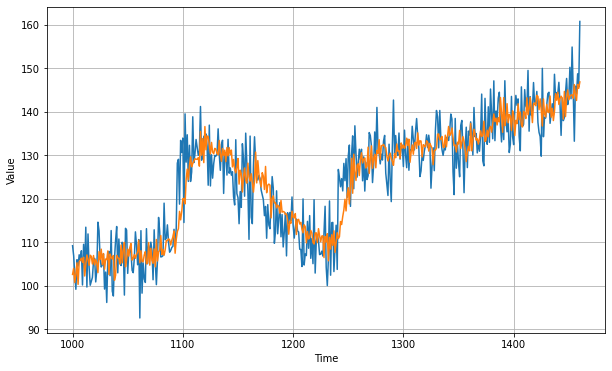

In [9]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.658141

Tuning the Learning Rate

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(1e-08, 0.001, 0.0, 300.0)

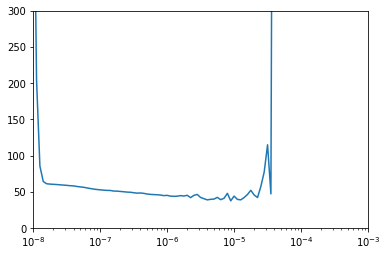

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-06, 0.0001, 0.0, 300.0)

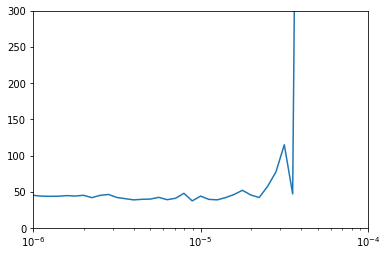

In [13]:
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 300])

In [15]:
window_size = 40
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=50, verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
30/30 [==============================] - 1s 5ms/step - loss: 292.9523
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 57.6686
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 47.1217
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 42.6823
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 42.0400
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 41.3573
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 39.8390
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 43.6150
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 55.3747
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 48.4953
Epoch 11/50
30/30 [==============================] - 0s 4ms/step - loss: 46.7070
Epoch 12/50
30/30 [==============================] - 0s 4ms/step - loss: 43.6579
Epoch 13/50
30/30 [=================

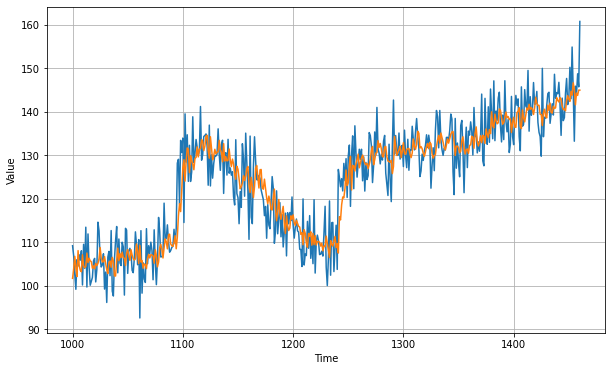

In [16]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.507421